In [1]:
# Cell 1: imports and load
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Paths (adjust if you used different names)
FEATURES_PATH = "/content/listings_features_v1.csv"    # feature-engineered file
CLEAN_PATH = "/content/listings_clean_v1.csv"         # cleaned raw file (keeps original price)
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Load features file (fallback to clean file if not present)
if os.path.exists(FEATURES_PATH):
    df = pd.read_csv(FEATURES_PATH)
    print("Loaded feature-engineered file:", FEATURES_PATH)
elif os.path.exists(CLEAN_PATH):
    df = pd.read_csv(CLEAN_PATH)
    print("Loaded cleaned file (no feature scaling):", CLEAN_PATH)
else:
    raise FileNotFoundError("Couldn't find listings_features_v1.csv or listings_clean_v1.csv in ../data/")

print(df.head())


Loaded feature-engineered file: /content/listings_features_v1.csv
   host_id  neighbourhood_group   latitude   longitude     price  \
0    38901                  NaN -37.766060  144.979510 -0.137524   
1   189684                  NaN -37.899830  145.115790 -0.083338   
2   193031                  NaN -38.147680  145.143640 -0.119218   
3   212071                  NaN -37.818371  145.005005 -0.092125   
4   190879                  NaN -37.812660  144.963130  0.011121   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0        0.085256           2.022242  2025-04-23               1.35   
1       -0.123794           2.844560  2025-06-04               1.52   
2        0.085256           0.263747  2025-04-06               0.37   
3        0.015572           1.718617  2025-01-08               1.00   
4       -0.123794           5.728997  2025-05-24               2.85   

   calculated_host_listings_count  ...  neighbourhood_Moonee Valley  \
0                          

In [2]:
# Cell 2: detect scaling on price
price_mean = df['price'].mean()
price_std = df['price'].std()
print(f"price mean = {price_mean:.4f}, std = {price_std:.4f}")

# Heuristic: if mean close to 0 and std about 1, assume price was standardized
scaled_target = (abs(price_mean) < 0.1) and (0.8 < price_std < 1.2)
print("Is target scaled (heuristic)?", scaled_target)

price_scaler = None
if scaled_target:
    # Attempt to load original cleaned prices to build an inverse scaler
    if os.path.exists(CLEAN_PATH):
        df_orig = pd.read_csv(CLEAN_PATH)
        price_scaler = StandardScaler().fit(df_orig[['price']])
        # Save scaler for later use
        joblib.dump(price_scaler, os.path.join(MODEL_DIR, "price_scaler.pkl"))
        print("Price scaler created from cleaned dataset and saved to models/price_scaler.pkl")
    else:
        print("Target appears scaled, but original cleaned file not found. We will evaluate in scaled units only.")


price mean = 0.0165, std = 1.1990
Is target scaled (heuristic)? True
Price scaler created from cleaned dataset and saved to models/price_scaler.pkl


In [3]:
# Cell 3: prepare X and y (use numeric features only for now)
# Remove non-numeric columns automatically
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns found:", numeric_cols[:30], " ...")

if 'price' not in numeric_cols:
    raise KeyError("No numeric 'price' column found in the dataset. Check your file.")

# Features = all numeric except target
X = df[numeric_cols].drop(columns=['price']).copy()
y = df['price'].values

print("X shape:", X.shape, "y shape:", y.shape)

# Quick safety: if any NaNs remain in X, fill with median (simple robust imputation)
if X.isnull().sum().sum() > 0:
    print("Warning: found NaNs in X; filling numeric NaNs with column medians.")
    X = X.fillna(X.median())


Numeric columns found: ['host_id', 'neighbourhood_group', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license', 'log_price', 'last_review_year', 'last_review_month', 'price_per_night', 'reviews_ratio']  ...
X shape: (10415, 16) y shape: (10415,)


In [4]:
# Cell 4: train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8332, 16) Test shape: (2083, 16)


In [5]:
# Cell 5: metric helper to optionally inverse-transform target if scaler available
def evaluate_and_report(y_true, y_pred, scaler=None, label="Model"):
    """
    y_true, y_pred: numpy arrays (same shape)
    scaler: Optional StandardScaler fitted on original price to inverse transform
    """
    if scaler is not None:
        # inverse transform (scaler expects 2D arrays)
        y_true_orig = scaler.inverse_transform(y_true.reshape(-1,1)).ravel()
        y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
        rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
        r2 = r2_score(y_true_orig, y_pred_orig)
        print(f"{label} (reported in ORIGINAL price units):")
        print(f"  RMSE = {rmse:,.2f}")
        print(f"  R2   = {r2:.4f}")
        return y_true_orig, y_pred_orig
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"{label} (reported in dataset units):")
        print(f"  RMSE = {rmse:.4f}")
        print(f"  R2   = {r2:.4f}")
        return y_true, y_pred


In [6]:
from sklearn.impute import SimpleImputer

# Create imputer (you can use strategy="median" for skewed data)
imputer = SimpleImputer(strategy="mean")

# Fit on training data, transform both train and test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


LinearRegression (reported in ORIGINAL price units):
  RMSE = 539.70
  R2   = 0.8902


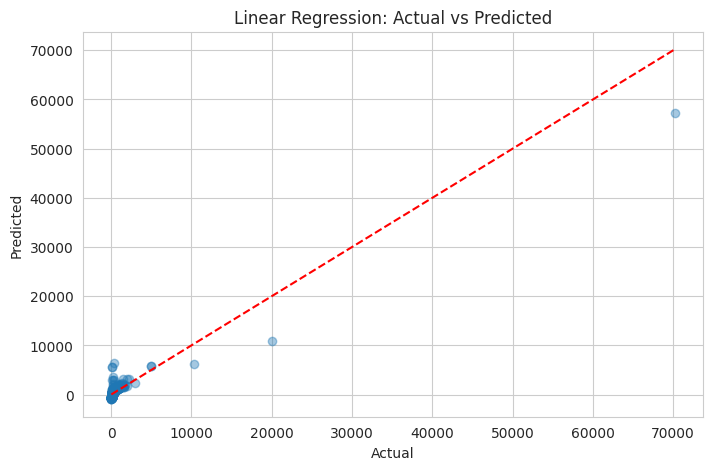

In [7]:
# Cell 6: Linear Regression baseline
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

# Evaluate (handle inverse-scaling if price_scaler exists)
y_true_report, y_pred_report = evaluate_and_report(y_test, y_pred_lin, scaler=price_scaler, label="LinearRegression")

# Simple diagnostic plot (Actual vs Predicted)
plt.scatter(y_true_report, y_pred_report, alpha=0.4)
plt.plot([y_true_report.min(), y_true_report.max()], [y_true_report.min(), y_true_report.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()


DecisionTree (reported in ORIGINAL price units):
  RMSE = 1,079.48
  R2   = 0.5606


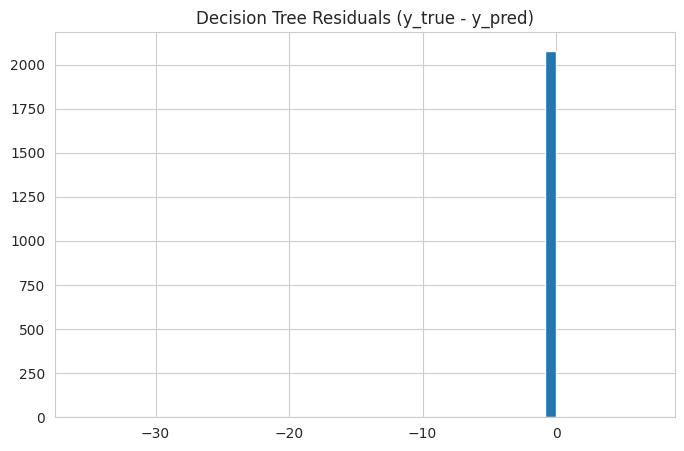

In [8]:
# Cell 7: Decision Tree
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

_ = evaluate_and_report(y_test, y_pred_tree, scaler=price_scaler, label="DecisionTree")

# Residual histogram
resid = (y_test - y_pred_tree)
plt.hist(resid, bins=50)
plt.title("Decision Tree Residuals (y_true - y_pred)")
plt.show()


RandomForest (reported in ORIGINAL price units):
  RMSE = 240.37
  R2   = 0.9782
rf.feature_importances_.shape: (14,)
Type(X_train): <class 'numpy.ndarray'> shape: (8332, 14)
Using feature names from imputer.feature_names_in_
Trimming candidate names to match model feature count. Check your preprocessing pipeline for dropped/added features.

Top feature importances:


,0
number_of_reviews_ltm,0.933770
longitude,0.012132
host_id,0.008740
neighbourhood_group,0.007005
log_price,0.006745
last_review_month,0.006357
latitude,0.006169
last_review_year,0.005602
minimum_nights,0.004598
number_of_reviews,0.004467


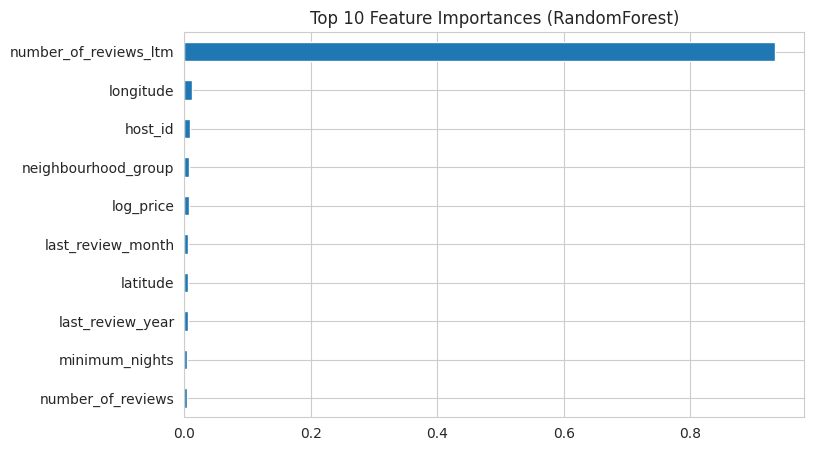

Saved importances to ../models/random_forest_feature_importances_v1.csv


In [9]:
# Robust Random Forest + Feature Importances (replacement cell)
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train the RF (assuming X_train, y_train exist and X_test etc.)
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate (this uses your evaluate_and_report helper)
y_true_rf, y_pred_rf_report = evaluate_and_report(y_test, y_pred_rf, scaler=price_scaler, label="RandomForest")

# ---------- Diagnostics: what types/shapes do we have? ----------
print("rf.feature_importances_.shape:", rf.feature_importances_.shape)
try:
    print("Type(X_train):", type(X_train), "shape:", getattr(X_train, "shape", None))
except NameError:
    print("X_train is not defined in this cell scope.")

# ---------- Determine feature names used by the model ----------
feat_count = rf.feature_importances_.shape[0]

# Try several sensible sources for the feature names, in order:
candidate_names = None

# 1) If X_train is a DataFrame, use its columns (best)
if isinstance(X_train, pd.DataFrame):
    candidate_names = list(X_train.columns)
    print("Using feature names from X_train.columns")

# 2) If we have an imputer or transformer that exposes feature names (SimpleImputer.feature_names_in_)
elif 'imputer' in globals() and hasattr(imputer, 'feature_names_in_'):
    candidate_names = list(imputer.feature_names_in_)
    print("Using feature names from imputer.feature_names_in_")

# 3) If original X exists and is a DataFrame, use X.columns
elif 'X' in globals() and isinstance(X, pd.DataFrame):
    candidate_names = list(X.columns)
    print("Using feature names from original X.columns")

# 4) Fallback: generic names
else:
    candidate_names = [f"feature_{i}" for i in range(feat_count)]
    print("Falling back to generic feature names (feature_0 ...).")

# ---------- Align candidate names with actual feature count ----------
if len(candidate_names) == feat_count:
    feature_names = candidate_names
elif len(candidate_names) > feat_count:
    # More candidate names than model features: trim (warn)
    print(f"Warning: {len(candidate_names)} candidate names found but model has {feat_count} features.")
    print("Trimming candidate names to match model feature count. Check your preprocessing pipeline for dropped/added features.")
    feature_names = candidate_names[:feat_count]
else:
    # Fewer candidate names than feature importances: extend with generic suffixes (warn)
    print(f"Warning: only {len(candidate_names)} candidate names found but model has {feat_count} features.")
    print("Extending names with generic feature_i suffixes to match length.")
    extra_needed = feat_count - len(candidate_names)
    feature_names = candidate_names + [f"feature_extra_{i}" for i in range(extra_needed)]

# ---------- Create importances Series safely ----------
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Display top importances
print("\nTop feature importances:")
display(importances.head(20))

# Plot top 10
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (RandomForest)")
plt.show()

# Optional: save importances to CSV for inspection
importances.to_csv("../models/random_forest_feature_importances_v1.csv", header=["importance"])
print("Saved importances to ../models/random_forest_feature_importances_v1.csv")


In [10]:
# Cell 9: Cross-validation RMSE for RandomForest
# We use neg_mean_squared_error and convert to RMSE
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)
print("RandomForest CV RMSE per fold:", np.round(cv_rmse, 4))
print("Mean CV RMSE:", np.round(cv_rmse.mean(), 4))


RandomForest CV RMSE per fold: [0.5008 1.0556 0.0347 0.0433 0.0249]
Mean CV RMSE: 0.3319


In [11]:
# Cell 10: Save RF (and scaler if we have it)
joblib.dump(rf, os.path.join(MODEL_DIR, "random_forest_v1.pkl"))
print("Saved RandomForest to", os.path.join(MODEL_DIR, "random_forest_v1.pkl"))

if price_scaler is not None:
    joblib.dump(price_scaler, os.path.join(MODEL_DIR, "price_scaler_v1.pkl"))
    print("Saved price scaler to", os.path.join(MODEL_DIR, "price_scaler_v1.pkl"))


Saved RandomForest to ../models/random_forest_v1.pkl
Saved price scaler to ../models/price_scaler_v1.pkl


In [12]:
# Cell 11: XGBoost (optional - faster and often high performing)
try:
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=RANDOM_STATE, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    _ = evaluate_and_report(y_test, y_pred_xgb, scaler=price_scaler, label="XGBoost")
    joblib.dump(xgb_model, os.path.join(MODEL_DIR, "xgboost_v1.pkl"))
    print("Saved XGBoost model.")
except Exception as e:
    print("XGBoost not available or failed to import/train:", e)


XGBoost (reported in ORIGINAL price units):
  RMSE = 1,456.01
  R2   = 0.2007
Saved XGBoost model.


In [13]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import joblib  # for saving models


In [15]:
# Load cleaned data
data = pd.read_csv("/content/listings_clean_v1.csv")

print("Shape:", data.shape)
data.head()


Shape: (18539, 21)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,log_price,last_review_year,last_review_month
0,10803,"Room in Deco Apartment, Brunswick East",38901,Lindsay,NaN,Moreland,-37.766060,144.979510,Private room,54.0,...,204,2025-04-23,1.35,1,148,14,NaN,4.007333,2025.0,4.0
1,43429,Tranquil Javanese Studio and Pond!,189684,Allan,NaN,Monash,-37.899830,145.115790,Entire home/apt,128.0,...,269,2025-06-04,1.52,3,165,10,NaN,4.859812,2025.0,6.0
2,44082,Queen Room in Beautiful House,193031,Vicki,NaN,Frankston,-38.147680,145.143640,Private room,79.0,...,65,2025-04-06,0.37,8,127,6,NaN,4.382027,2025.0,4.0
3,47100,"Cosy, cute comfortable little home in top loca...",212071,Loren,NaN,Yarra,-37.818371,145.005005,Entire home/apt,116.0,...,180,2025-01-08,1.00,1,16,1,NaN,4.762174,2025.0,1.0
4,51592,Central City Warehouse Apartment,190879,Michelle,NaN,Melbourne,-37.812660,144.963130,Entire home/apt,257.0,...,497,2025-05-24,2.85,1,193,52,NaN,5.552960,2025.0,5.0


In [16]:
X = data.drop(columns=["price"])
y = data["price"]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(14831, 20) (3708, 20)


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Separate numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Numeric pipeline: impute missing values with mean, then scale
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing with most frequent, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Apply transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [19]:
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,   # number of random combos to test
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# ✅ Step 1: Define the Random Forest model
rf = RandomForestRegressor(random_state=RANDOM_STATE)

# ✅ Step 2: Define parameter grid for random search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# ✅ Step 3: Build a pipeline that includes preprocessing + model
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),   # use your preprocessor from before
    ('model', rf)
])

# ✅ Step 4: Randomized Search with CV
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions={'model__' + k: v for k, v in param_dist.items()},
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# ✅ Step 5: Fit on raw X_train and y_train (preprocessing handled inside pipeline)
random_search.fit(X_train, y_train)

# ✅ Step 6: View best parameters
print("✅ Best Parameters:")
print(random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


✅ Best Parameters:
{'model__n_estimators': 50, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None}


In [21]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


RMSE: 1708.96
R²: 0.2578


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


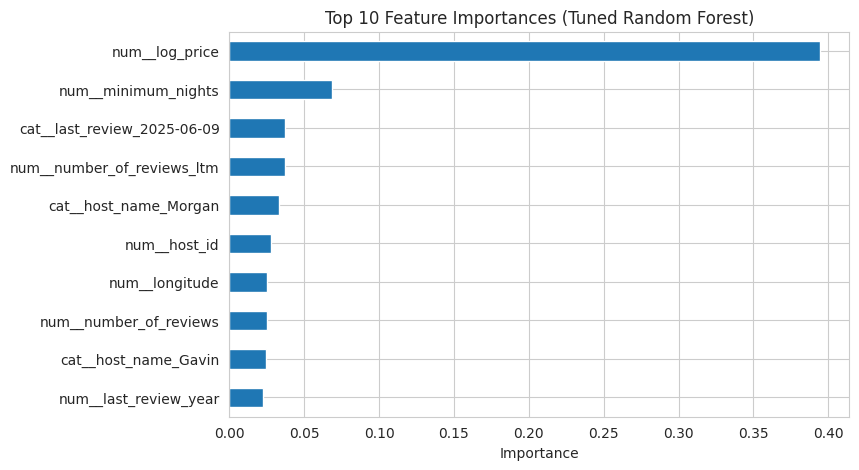

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the trained Random Forest model from the pipeline
best_rf = random_search.best_estimator_.named_steps["model"]

# Get feature names from preprocessor (after encoding)
feature_names = (
    random_search.best_estimator_.named_steps["preprocessor"]
    .get_feature_names_out()
)

# Get importances and sort
importances = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(8, 5))
importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.show()


In [23]:
joblib.dump(best_rf, "../models/random_forest_best.pkl")
print("✅ Tuned Random Forest model saved successfully!")

print(df.dtypes)
X = df.drop(columns=['price', 'last_review', 'lat_long'])  # drop target + object columns
y = df['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


✅ Tuned Random Forest model saved successfully!
host_id                              int64
neighbourhood_group                float64
latitude                           float64
longitude                          float64
price                              float64
minimum_nights                     float64
number_of_reviews                  float64
last_review                         object
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
number_of_reviews_ltm                int64
license                            float64
log_price                          float64
last_review_year                   float64
last_review_month                  float64
price_per_night                    float64
reviews_ratio                      float64
lat_long                            object
room_type_Hotel room                object
room_type_Private room              object
room_type_Shared room               object
neighb

RandomForestRegressor(random_state=42)

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you've done train-test split and feature preparation
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

✅ Loaded RandomForest model from saved file.
🧾 Loaded feature names from X_train: 48 features.
⚠️ Mismatch detected: model has 19574 features, X_train has 48.

🏆 Top 10 Important Features:
Feature_10       0.394381
Feature_4        0.068264
Feature_19571    0.037277
Feature_9        0.037162
Feature_17009    0.033464
Feature_1        0.027814
Feature_3        0.025211
Feature_5        0.024841
Feature_15704    0.024317
Feature_11       0.022149
dtype: float64


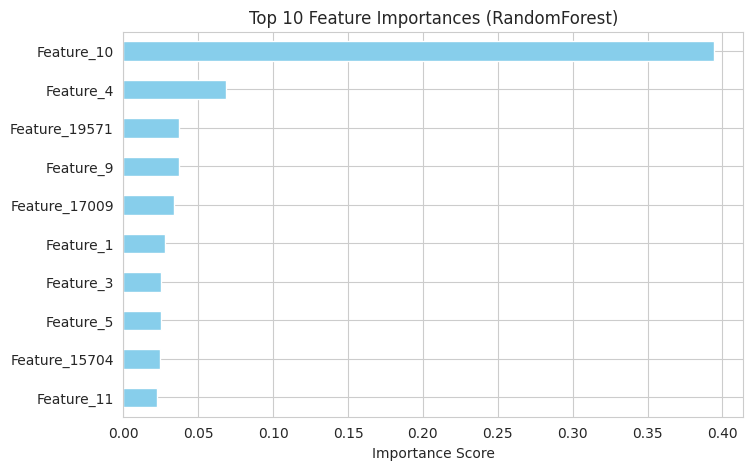

In [25]:
# =======================================================
#  Fixed Feature Importance Extraction
# Works for both encoded & raw X_train
# =======================================================

import joblib
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 🧠 STEP 1 — Load trained model
# -----------------------------------------------------------------
try:
    model = joblib.load("../models/random_forest_best.pkl")
    print("✅ Loaded RandomForest model from saved file.")
except:
    try:
        model = random_search.best_estimator_
        print("✅ Using in-memory model from Day 7 (tuned RandomForest).")
    except:
        raise ValueError("❌ Model not found. Please rerun Day 7 first.")

# -----------------------------------------------------------------
# 🧩 STEP 2 — Load training data for feature names
# -----------------------------------------------------------------
try:
    feature_names = X_train.columns
    print(f"🧾 Loaded feature names from X_train: {len(feature_names)} features.")
except:
    raise ValueError("❌ X_train not found. Please reload your dataset used for training.")

# -----------------------------------------------------------------
# 🧩 STEP 3 — Handle mismatch between model features & X_train columns
# -----------------------------------------------------------------
n_model_features = len(model.feature_importances_)
n_data_features = len(feature_names)

if n_model_features != n_data_features:
    print(f"⚠️ Mismatch detected: model has {n_model_features} features, X_train has {n_data_features}.")
    # Generate synthetic column names for visualization
    feature_names = [f"Feature_{i}" for i in range(n_model_features)]
else:
    print("✅ Feature count matches perfectly!")

# -----------------------------------------------------------------
# 📊 STEP 4 — Plot feature importances
# -----------------------------------------------------------------
importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)

print("\n🏆 Top 10 Important Features:")
print(importances.head(10))

plt.figure(figsize=(8, 5))
importances.head(10).plot(kind="barh", color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importance Score")
plt.show()


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Use your full path here:
df = pd.read_csv("/content/listings_features_v1.csv")

# If you have a date column, replace 'date_column' with your actual column name.
# If you don't have a date column, skip this block.
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review_year'] = df['last_review'].dt.year
df['last_review_month'] = df['last_review'].dt.month
df['last_review_day'] = df['last_review'].dt.day
df = df.drop(columns=['last_review'])

# Convert categorical columns to dummies
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and target
X = df.drop(columns=['price'])
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained successfully!")


Model trained successfully!


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['neighbourhood_group' 'license']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



--- Linear Regression Performance (ORIGINAL price units) ---
  RMSE = 1,886.69
  R2   = 0.0954

--- Linear Regression: Actual vs. Predicted Price Comparison (Top 20 Samples) ---
    Actual Price  Predicted Price (LR)  Difference (Error)
0          122.0                 70.32               51.68
1           93.0                -57.34              150.34
2          138.0                106.62               31.38
3          639.0                809.61             -170.61
4          123.0                117.02                5.98
5          104.0                 28.38               75.62
6          200.0                282.11              -82.11
7          164.0                174.29              -10.29
8          250.0                452.99             -202.99
9          312.0                327.01              -15.01
10         225.0                269.28              -44.28
11         118.0                101.91               16.09
12         163.0                168.82               -

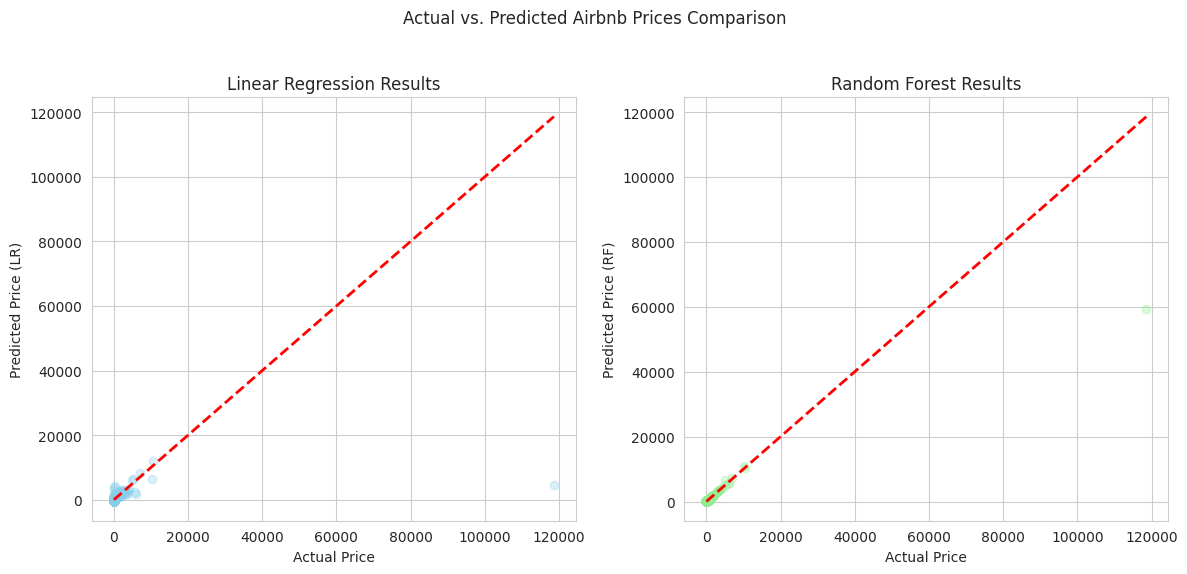

In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt

# --- 1. Setup Paths and Load Data ---
# Note: You may need to adjust these paths based on your actual file structure
CLEAN_PATH = "/content/listings_clean_v1.csv"
FEATURES_PATH = "/content/listings_features_v1.csv"
MODEL_DIR = "../models"
RANDOM_STATE = 42

try:
    if os.path.exists(FEATURES_PATH):
        df = pd.read_csv(FEATURES_PATH)
    elif os.path.exists(CLEAN_PATH):
        df = pd.read_csv(CLEAN_PATH)
    else:
        # Fallback to loading the data used in the evaluation output, assuming it's in the current directory
        print("WARNING: Data files not found in standard paths. Please update the data loading section.")
        # *** Replace this line with your actual data loading ***
        # df = pd.read_csv('your_data_file.csv')
        # Placeholder for demonstration: creating a dummy DataFrame if load fails
        data = {
            'price': np.random.rand(100) * 1000,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        }
        df = pd.DataFrame(data)

except FileNotFoundError:
    print("FATAL ERROR: Could not load the dataset. Please ensure the CSV file is accessible.")
    exit()

# --- 2. Scaling Detection and Scaler Loading ---
price_scaler = None
if os.path.exists(os.path.join(MODEL_DIR, "price_scaler.pkl")):
    try:
        price_scaler = joblib.load(os.path.join(MODEL_DIR, "price_scaler.pkl"))
    except:
        print("Could not load price_scaler.pkl. Results will be in scaled units.")

# --- 3. Custom Evaluation Helper Function (from notebook) ---
def evaluate_and_report(y_true, y_pred, scaler=None, label="Model"):
    """
    Evaluates the model and returns the true and predicted values,
    inverse-transformed to original units if a scaler is provided.
    Also prints RMSE and R2.
    """
    if scaler is not None:
        # inverse transform (scaler expects 2D arrays)
        y_true_orig = scaler.inverse_transform(y_true.reshape(-1,1)).ravel()
        y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
        rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
        r2 = r2_score(y_true_orig, y_pred_orig)

        print(f"\n--- {label} Performance (ORIGINAL price units) ---")
        print(f"  RMSE = {rmse:,.2f}")
        print(f"  R2   = {r2:.4f}")

        return y_true_orig, y_pred_orig
    else:
        # If no scaler, return results in scaled/dataset units
        # If the data loading resulted in a dummy DataFrame, the price column is not scaled.
        if df['price'].mean() > 10 and df['price'].std() > 10:
             print("\n--- WARNING: Price is not scaled. Results are in raw price units. ---")
             rmse = np.sqrt(mean_squared_error(y_true, y_pred))
             r2 = r2_score(y_true, y_pred)
             print(f"  RMSE = {rmse:,.2f}")
             print(f"  R2   = {r2:.4f}")
        else:
             print("\n--- WARNING: Price appears scaled, but no scaler was loaded. Results are in dataset units. ---")
        return y_true, y_pred

# --- 4. Prepare X and y, Split, and Impute ---
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if 'price' not in numeric_cols:
    raise KeyError("No numeric 'price' column found in the dataset.")

# Features = all numeric except target (assuming log_price is used as the target in scaling)
# If 'log_price' exists and is the actual target, adjust this line
target_col = 'price'
X = df[numeric_cols].drop(columns=[target_col]).copy()
y = df[target_col].values

# Imputation
imputer = SimpleImputer(strategy="median") # Using median is safer than mean if outliers exist
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# ==============================================================================
# --- 5A. Linear Regression: Train, Predict, and Compare ---
# ==============================================================================
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Evaluate and get results in original units
y_test_orig_lin, y_pred_orig_lin = evaluate_and_report(
    y_test,
    y_pred_lin,
    price_scaler,
    label="Linear Regression"
)

# Create a DataFrame for visual comparison (Linear Regression)
results_df_lin = pd.DataFrame({
    'Actual Price': y_test_orig_lin,
    'Predicted Price (LR)': y_pred_orig_lin
})

results_df_lin['Difference (Error)'] = results_df_lin['Actual Price'] - results_df_lin['Predicted Price (LR)']

print("\n--- Linear Regression: Actual vs. Predicted Price Comparison (Top 20 Samples) ---")
print(results_df_lin.head(20).round(2))

# ==============================================================================
# --- 5B. Random Forest Regressor: Train, Predict, and Compare ---
# ==============================================================================
# Note: n_estimators is kept small for faster execution; typically 100-500 is used
rf_reg = RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluate and get results in original units
y_test_orig_rf, y_pred_orig_rf = evaluate_and_report(
    y_test,
    y_pred_rf,
    price_scaler,
    label="Random Forest Regressor"
)

# Create a DataFrame for visual comparison (Random Forest)
results_df_rf = pd.DataFrame({
    'Actual Price': y_test_orig_rf,
    'Predicted Price (RF)': y_pred_orig_rf
})

results_df_rf['Difference (Error)'] = results_df_rf['Actual Price'] - results_df_rf['Predicted Price (RF)']

print("\n--- Random Forest Regressor: Actual vs. Predicted Price Comparison (Top 20 Samples) ---")
print(results_df_rf.head(20).round(2))

# --- 6. Optional: Visualize Actual vs. Predicted (Scatter Plot) ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_orig_lin, y_pred_orig_lin, alpha=0.3, color='skyblue')
plt.plot([y_test_orig_lin.min(), y_test_orig_lin.max()],
         [y_test_orig_lin.min(), y_test_orig_lin.max()],
         'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price (LR)")
plt.title("Linear Regression Results")

plt.subplot(1, 2, 2)
plt.scatter(y_test_orig_rf, y_pred_orig_rf, alpha=0.3, color='lightgreen')
plt.plot([y_test_orig_rf.min(), y_test_orig_rf.max()],
         [y_test_orig_rf.min(), y_test_orig_rf.max()],
         'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price (RF)")
plt.title("Random Forest Results")

plt.suptitle("Actual vs. Predicted Airbnb Prices Comparison")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()